In [ ]:
!nvidia-smi 

Mon May 31 09:40:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Notes

Days back, I've shared this [infernece kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-inference). But its weights are static as you can't retrain the model. In this work, I'm gonna release the training notebook which is almost my internal training pipeline. I removed some experimentation ideas to make things clearer and straightforward. Don't mind adding new ideas at your side as well.

To make the training faster, we cached the training set into RAM. The whole training records are already [converted into handy  melspecs images](https://www.kaggle.com/kneroma/kkiller-birdclef-2021). These images are from 7 seconds extracts (training on 7 seconds seems to be more effective than 5 seconds). Longer records are truncated into random 7x10 seconds.

**If one is interessted in to the whole records' melspecs** (no truncation):
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part1
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part2
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part3
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part4

### Tips & suggestions
* You can choose a wide set of models from the **get_model** interface : ["resnest*", "resnet*", "resnext*", "efficientnet*" ...]
* You can change the learning rate scheduler: OneCycle ? ReduceOnPlateau ?
* Adds secondary labels
* Use train & test metadata (dates, positions (longitude, latitude), ...)
* Add melspecs augmentation

**For Colab training, you just have to uncomment the first cells**

# Versions

* **v1** : initial version
* **v3** : enable training on whole (no truncation) record melspecs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
! mkdir ~/.kaggle
! cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time

import os
if not os.path.exists("/content/datasets/audio_images"):
  !mkdir datasets
  !kaggle datasets download -d kneroma/kkiller-birdclef-2021
  !unzip /content//kkiller-birdclef-2021.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/audio_images/whcspa/XC206125.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC206127.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC206129.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC206153.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC206154.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC207793.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC216470.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC216472.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC217426.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC236238.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC236240.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC236241.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC236243.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC237362.ogg.npy  
  inflating: datasets/audio_images/whcspa/XC237740.ogg.npy  
  inflating: datasets/audio_images

In [ ]:
!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest timm torchlibrosa

     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 348kB 14.5MB/s 
     |████████████████████████████████| 163kB 21.9MB/s 


In [ ]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from torchlibrosa.augmentation import SpecAugmentation

# from resnest.torch import resnest50
import timm

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [ ]:
# from efficientnet_pytorch import EfficientNet
# import pretrainedmodels
# import resnest.torch as resnest_torch

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
NUM_CLASSES = 281
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 5 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

# For colab
DATA_ROOT = Path("/content/datasets/")
TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")
MODEL_ROOT = Path("/content/drive/My Drive/Kaggle/BirdClef2021/models")

soundscape_mel_path = '/content/drive/MyDrive/Kaggle/soundscapes_mel/'
soundscape_label = '/content/drive/MyDrive/Kaggle/BirdClef2021/train_soundscape_labels.csv'

# For local 
# DATA_ROOT = Path("/home/menoo/code/BirdCLEF_2021/kkiller/")
# TRAIN_IMAGES_ROOT = Path("/home/menoo/code/BirdCLEF_2021/kkiller/audio_images/")
# TRAIN_LABELS_FILE = Path("/home/menoo/code/BirdCLEF_2021/kkiller/rich_train_metadata.csv")
# MODEL_ROOT = Path("/home/menoo/code/BirdCLEF_2021/kkiller/models")

# DATA_ROOT = Path("../input/birdclef-2021")
# TRAIN_IMAGES_ROOT = Path("../input/kkiller-birdclef-2021/audio_images")
# TRAIN_LABELS_FILE = Path("../input/kkiller-birdclef-2021/rich_train_metadata.csv")

# MEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
# TRAIN_LABEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

# MODEL_ROOT = Path(".")

In [ ]:
soundscapes = pd.read_csv(soundscape_label)

In [ ]:
soundscapes

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall
...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall
2396,54955_SSW_585,SSW,54955,585,grycat
2397,54955_SSW_590,SSW,54955,590,grycat
2398,54955_SSW_595,SSW,54955,595,nocall


In [ ]:
soundscape_mel = []
for dirname, _, filenames in os.walk(soundscape_mel_path):
    for filename in soundscapes.audio_id.unique():
      soundscape_mel.append(os.path.join(dirname, str(filename)+'.npy'))
soundscape_mel

['/content/drive/MyDrive/Kaggle/soundscapes_mel/7019.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/7954.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/11254.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/18003.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/21767.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/26746.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/31928.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/44957.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/50878.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/57610.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/2782.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/7843.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/10534.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/14473.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/20152.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_mel/26709.npy',
 '/content/drive/MyDrive/Kaggle/soundscapes_

In [ ]:
no_call = [5,0,3,1,41,4,0,0,4,3,1,0,10,4,2,8,28,28,1]

In [ ]:
len(no_call)

19

In [ ]:
no_call_mels = []
for mel, call in zip(soundscape_mel, no_call):
  # print(en)
  a = np.load(mel)
  m = a[call]
  # lbd.specshow(m)
  # plt.show()
  no_call_mels.append(m)
print(len(no_call_mels))

19


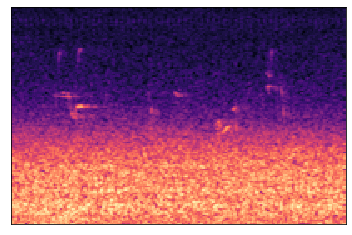

In [ ]:
lbd.specshow(a[2])

In [ ]:
target_columns = ['acafly', 'acowoo', 'aldfly', 'ameavo', 'amecro', 'amegfi',
       'amekes', 'amered', 'amerob', 'andsol1', 'astfly', 'azaspi1',
       'babwar', 'balori', 'banana', 'banwre1', 'barant1', 'barswa',
       'bawswa1', 'bawwar', 'baywre1', 'bbwduc', 'bewwre', 'bkbwar',
       'bkcchi', 'bkhgro', 'bkmtou1', 'bknsti', 'blbgra1', 'blbthr1',
       'blcjay1', 'blctan1', 'blkpho', 'blsspa1', 'blugrb1', 'blujay',
       'bnhcow', 'bobfly1', 'brbmot1', 'brcvir1', 'brebla', 'brncre',
       'brnjay', 'brnthr', 'brratt1', 'brwhaw', 'btbwar', 'btnwar',
       'btywar', 'bucmot2', 'buggna', 'bugtan', 'buhvir', 'bulori',
       'burwar1', 'bushti', 'butsal1', 'buwtea', 'calqua', 'caltow',
       'cangoo', 'canwar', 'carwre', 'casfin', 'caster1', 'casvir',
       'ccbfin', 'cedwax', 'chbant1', 'chbwre1', 'chcant2', 'chispa',
       'chswar', 'clcrob', 'cocwoo1', 'colcha1', 'coltro1', 'commer',
       'compau', 'compot1', 'comrav', 'comyel', 'cotfly1', 'cowscj1',
       'daejun', 'dowwoo', 'ducfly', 'dusfly', 'easblu', 'easkin',
       'easmea', 'easpho', 'eastow', 'eawpew', 'eucdov', 'eursta',
       'fiespa', 'flrtan1', 'gartro1', 'gbbgul', 'gbwwre1', 'gcrwar',
       'gnttow', 'gocfly1', 'gockin', 'goftyr1', 'gohque1', 'goowoo1',
       'grasal1', 'grbani', 'grbher3', 'grcfly', 'grekis', 'grethr1',
       'grhcha1', 'grhowl', 'grnjay', 'grtgra', 'grycat', 'haiwoo',
       'herthr', 'herwar', 'higmot1', 'houfin', 'houwre', 'incdov',
       'indbun', 'kebtou1', 'killde', 'larspa', 'laufal1', 'lazbun',
       'leafly', 'lesgol', 'lesvio1', 'linspa', 'linwoo1', 'littin1',
       'lobgna5', 'lotduc', 'lotman1', 'macwar', 'magwar', 'marwre',
       'meapar', 'monoro1', 'mouchi', 'moudov', 'mouela1', 'mouqua',
       'mouwar', 'naswar', 'norcar', 'norfli', 'normoc', 'norpar',
       'norwat', 'nutwoo', 'oaktit', 'obnthr1', 'olsfly', 'orbeup1',
       'orbspa1', 'orcpar', 'orfpar', 'ovenbi1', 'pabspi1', 'paltan1',
       'palwar', 'phivir', 'pibgre', 'pilwoo', 'pirfly1', 'plawre1',
       'plsvir', 'plupig2', 'prowar', 'purfin', 'putfru1', 'pygnut',
       'rawwre1', 'rcatan1', 'rebnut', 'rebsap', 'rebwoo', 'redcro',
       'reevir1', 'rehbar1', 'rethaw', 'rewbla', 'ribgul', 'roahaw',
       'robgro', 'rocpig', 'rtlhum', 'rubpep1', 'rubwre1', 'ruckin',
       'rucspa1', 'rucwar', 'rucwar1', 'rugdov', 'rumfly1', 'rutjac1',
       'saffin', 'sancra', 'savspa', 'scatan', 'scbwre1', 'scptyr1',
       'scrtan1', 'sobtyr1', 'socfly1', 'sonspa', 'soulap1', 'spotow',
       'spvear1', 'squcuc1', 'stejay', 'sthant1', 'strcuc1', 'strfly1',
       'strsal1', 'sumtan', 'swaspa', 'swathr', 'tenwar', 'thbeup1',
       'thswar1', 'towsol', 'treswa', 'trogna1', 'trokin', 'tromoc',
       'tropar', 'tuftit', 'veery', 'vigswa', 'warvir', 'wbwwre1',
       'webwoo1', 'wesant1', 'wesblu', 'weskin', 'wesmea', 'westan',
       'wewpew', 'whbman1', 'whevir', 'whiwre1', 'whtdov', 'whtspa',
       'whwbec1', 'wilfly', 'wiltur', 'wlswar', 'wooduc', 'woothr',
       'wrenti', 'yebcha', 'yebela1', 'yebfly', 'yebori1', 'yebsap',
       'yebsee1', 'yefgra1', 'yegvir', 'yehbla', 'yehcar1', 'yelwar',
       'yerwar', 'yeteup1', 'yetvir', 'comgra', 'runwre1', 'belkin1',
       'hofwoo1', 'sthwoo1', 'crfpar', 'whcpar', 'melbla1']

In [ ]:
TRAIN_BATCH_SIZE = 64
TRAIN_NUM_WORKERS = 4

VAL_BATCH_SIZE = 64
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [ ]:
# def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
#   df = None
#   LABEL_IDS = {}
    
#   for file_path in mel_paths:
#     temp = pd.read_csv(str(file_path), index_col=0)
#     temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
#     df = temp if df is None else df.append(temp)
    
#   df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

#   for file_path in train_label_paths:
#     with open(str(file_path)) as f:
#       LABEL_IDS.update(json.load(f))

#   return LABEL_IDS, df

In [ ]:
df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

df = df[df.rating > 2.0]
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(57379, 20)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,label_id,filepath,frames,sr,duration,fold
0,acafly,[amegfi],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3
3,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4
4,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2


In [ ]:
df = df[df['primary_label'].isin(target_columns)].reset_index(drop=True)
label_count = df['primary_label'].value_counts()
LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

df['label_id'] = df['primary_label'].map(LABEL_IDS)
# label_count = label_count[label_count > 150]
# for i, v in zip(label_count.index, label_count.values):
#   df.drop(df.rating[df.primary_label == i].sort_values()[:v-150].index, inplace=True)
# df = df.reset_index(drop=True)
df.shape

(43362, 20)

In [ ]:
sec_labels = []
for lst in df['secondary_labels']:
  l = []
  for lbl in lst:
    try:
      l.append(LABEL_IDS[lbl])
    except:
      continue
  sec_labels.append(l)
    
df["sec_lbl_id"] = np.array(sec_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
df["primary_label"].value_counts()

sonspa     500
comrav     500
barswa     500
redcro     500
eursta     500
          ... 
flrtan1     18
grhcha1     18
whcpar       9
runwre1      9
crfpar       7
Name: primary_label, Length: 281, dtype: int64

In [ ]:
df["label_id"].min(), df["label_id"].max()

(0, 280)

In [ ]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest" in name:
        # model = getattr(resnest_torch, name)(pretrained=True)
        # pretrained_weights = torch.load('../input/timm-resnest-weights/resnest50-528c19ca.pth')
        # model = getattr(resnest_torch, name)(pretrained=False)
        # model.load_state_dict(pretrained_weights)
        model = timm.create_model(name, pretrained=True)
    elif "wsl" in name:
        model = torch.hub.load("facebookresearch/WSL-Images", name)
    elif name.startswith("resnext") or  name.startswith("resnet"):
        model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    elif name.startswith("tf_efficientnet_b"):
        model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        # model = EfficientNet.from_pretrained(name)
        model = timm.create_model(name, pretrained=True)
    else:
        model = timm.create_model(name, pretrained=True)

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [ ]:
def load_data(df):
    def load_row(row):
        impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        # print(impath)
        # return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
        return row.filename, np.load(str(impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [ ]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

43362

In [ ]:
# def spec_augment(spec: np.ndarray, num_mask=2, 
#                  freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

#     spec = spec.copy()
#     for i in range(num_mask):
#         all_frames_num, all_freqs_num = spec.shape
#         freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
#         num_freqs_to_mask = int(freq_percentage * all_freqs_num)
#         f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
#         f0 = int(f0)
#         spec[:, f0:f0 + num_freqs_to_mask] = 0

#         time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
#         num_frames_to_mask = int(time_percentage * all_frames_num)
#         t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
#         t0 = int(t0)
#         spec[t0:t0 + num_frames_to_mask, :] = 0
    
#     return spec

In [ ]:
no_call_mels_7 = []
for m in no_call_mels:
  print(m.shape)
  if m.shape[-1] == 201:
    no_call_mels_7.append(np.concatenate([m[:,:40],m, m[:,161:]],axis=1))

(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)
(128, 201)


In [ ]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
        # self.spec_augmentor = SpecAugmentation(time_drop_width=64, time_stripes_num=2,
        #                         freq_drop_width=8, freq_stripes_num=2)
    
    @staticmethod
    def normalize(image):
        # image = image.astype("float32", copy=False) / 255.0
        image = image.astype("float32", copy=False) 
        image = image - np.mean(image)
        std = 1 if np.std(image) < 1e-6 else np.std(image)
        image = image/std
        
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.audio_image_store[row.filename]
        # print(idx)

        image2 = image[np.random.choice(len(image))]
        image = image[np.random.choice(len(image))]
        noise = no_call_mels_7[np.random.choice(len(no_call_mels_7))]
        noise2 = no_call_mels_7[np.random.choice(len(no_call_mels_7))]

        image = (self.normalize(image**2.4) + self.normalize(noise**2.4) )/2
        image = np.stack([image, image, image])

        image2 = (self.normalize(image2**2.4) + self.normalize(noise2**2.4) )/2
        image2 = np.stack([image2, image2, image2])
        
        # image2 = image2 
        # image2_p = image2 ** 2.4
        # image_m = image ** 0.5

        # image2 = np.stack([image2_p, image2_p, image2_p])

        # image_p = self.normalize(image_p)
        # image_m = self.normalize(image_m)
        # image = self.normalize(image)
        # image2 = self.normalize(image2)
        
        # image = np.stack([image_m, image_m, image_m])

        if self.is_train:
          # print(len(image))
          image = spec_augment(image)
          image2 = spec_augment(image2)
          
          

        t = np.zeros(self.num_classes, dtype=np.float32) + 0.00025 # Label smoothing
        t[row.sec_lbl_id] = 1
        t[row.label_id] = 1

        # return image, image2
        
        return (image,image2) ,(t,t)

In [ ]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(df)

43362

In [ ]:
def spec_augment(spec: np.ndarray, num_mask=3, 
                 freq_masking_max_percentage=0.12, time_masking_max_percentage=0.13):

    spec = spec.copy()
    for i in range(num_mask):
        _, all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[0,:, f0:f0 + num_freqs_to_mask] = 0
        spec[1,:, f0:f0 + num_freqs_to_mask] = 0
        spec[2,:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[0,t0:t0 + num_frames_to_mask, :] = 0
        spec[1,t0:t0 + num_frames_to_mask, :] = 0
        spec[2,t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

# Training the model

In [ ]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss

#         loss_fct = nn.BCEWithLogitsLoss(reduction='none')
# bce_loss = loss_fct(preds, targets)
# probas = torch.sigmoid(preds)
# loss = torch.where(targets >= 0.5, (1. - probas)**gamma * bce_loss, probas**gamma * bce_loss)
# loss = loss.mean()


class BCEFocal2WayLoss(nn.Module):
    def __init__(self, weights=[1, 1], class_weights=None):
        super().__init__()

        self.focal = BCEFocalLoss()

        self.weights = weights

    def forward(self, input, target):
        input_ = input["logit"]
        target = target.float()

        framewise_output = input["framewise_logit"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        loss = self.focal(input_, target)
        aux_loss = self.focal(clipwise_output_with_max, target)

        return self.weights[0] * loss + self.weights[1] * aux_loss

In [ ]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  # print(xb.shape)
  xb = xb.float()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [ ]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):
        xb = torch.cat([xb[0],xb[1]])
        yb = torch.cat([yb[0],yb[1]])

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        xb = xb.float()
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [ ]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      xb = torch.cat([xb[0],xb[1]])
      yb = torch.cat([yb[0],yb[1]])

      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  if  scheduler is not None:
    scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [ ]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    # if len(self.top_models) > self.top_k:
    #   old_model = self.root.joinpath(self.top_models[0])
    #   self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


In [ ]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()
  # criterion = BCEFocalLoss()

  optimizer = optim.Adam(net.parameters(), lr=8e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)
  # scheduler = None

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
  train_laoder = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
  val_laoder = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      saver.log(net, metrics)

In [ ]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)

      # print(fold, folds, train_set, val_set)  
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [ ]:
MODEL_NAMES = [
      "tf_efficientnet_b0",
      # "densenet121",
      # "resnest50d",
      # "resnest101e",
      # "tf_efficientnet_b4",
] 

In [ ]:
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    train(model_name, epochs=20, suffix=f"_sr{SR}_d{DURATION}_v002", folds=[4])
  except Exception as e:
    # print(f"Error {model_name} : \n{e}")

    raise ValueError() from  e



########################################### TF_EFFICIENTNET_B0



############################### [FOLD 4]


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


[00] loss: (0.042019, 0.034504) lrap: (0.071, 0.094) f1: (0.000, 0.001) rec: (0.002, 0.000) prec: (0.000, 0.277)


[01] loss: (0.032908, 0.030538) lrap: (0.155, 0.247) f1: (0.007, 0.045) rec: (0.004, 0.023) prec: (0.292, 0.650)


[02] loss: (0.029985, 0.028170) lrap: (0.279, 0.342) f1: (0.055, 0.130) rec: (0.029, 0.072) prec: (0.692, 0.695)


[03] loss: (0.027799, 0.025837) lrap: (0.371, 0.436) f1: (0.130, 0.235) rec: (0.072, 0.140) prec: (0.760, 0.729)


[04] loss: (0.026135, 0.024098) lrap: (0.435, 0.501) f1: (0.203, 0.283) rec: (0.117, 0.172) prec: (0.789, 0.806)


[05] loss: (0.024875, 0.023044) lrap: (0.480, 0.548) f1: (0.261, 0.336) rec: (0.156, 0.210) prec: (0.805, 0.837)


[06] loss: (0.023810, 0.022320) lrap: (0.518, 0.571) f1: (0.307, 0.380) rec: (0.190, 0.247) prec: (0.814, 0.819)


[07] loss: (0.022828, 0.021672) lrap: (0.550, 0.600) f1: (0.348, 0.440) rec: (0.222, 0.305) prec: (0.824, 0.790)


[08] loss: (0.022030, 0.020992) lrap: (0.574, 0.618) f1: (0.380, 0.440) rec: (0.248, 0.297) prec: (0.829, 0.845)


[09] loss: (0.021301, 0.020522) lrap: (0.595, 0.636) f1: (0.407, 0.462) rec: (0.271, 0.318) prec: (0.834, 0.842)


[10] loss: (0.020591, 0.020200) lrap: (0.616, 0.646) f1: (0.435, 0.486) rec: (0.295, 0.343) prec: (0.841, 0.831)


[11] loss: (0.019888, 0.020075) lrap: (0.635, 0.652) f1: (0.460, 0.495) rec: (0.317, 0.352) prec: (0.848, 0.831)


[12] loss: (0.019387, 0.019740) lrap: (0.649, 0.661) f1: (0.475, 0.513) rec: (0.331, 0.371) prec: (0.850, 0.834)


[13] loss: (0.018804, 0.019575) lrap: (0.665, 0.668) f1: (0.495, 0.516) rec: (0.349, 0.371) prec: (0.858, 0.844)


[14] loss: (0.018301, 0.019414) lrap: (0.679, 0.673) f1: (0.510, 0.532) rec: (0.364, 0.395) prec: (0.865, 0.814)


[15] loss: (0.017905, 0.019305) lrap: (0.689, 0.677) f1: (0.522, 0.539) rec: (0.375, 0.404) prec: (0.867, 0.809)


[16] loss: (0.017576, 0.019222) lrap: (0.698, 0.679) f1: (0.531, 0.543) rec: (0.385, 0.407) prec: (0.869, 0.812)


[17] loss: (0.017293, 0.019157) lrap: (0.704, 0.683) f1: (0.538, 0.545) rec: (0.390, 0.411) prec: (0.872, 0.809)


[18] loss: (0.017125, 0.019151) lrap: (0.711, 0.684) f1: (0.544, 0.546) rec: (0.397, 0.411) prec: (0.874, 0.814)


[19] loss: (0.017007, 0.019153) lrap: (0.713, 0.684) f1: (0.548, 0.547) rec: (0.400, 0.412) prec: (0.874, 0.812)



In [ ]:
se

In [ ]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu May 20 14:54:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    51W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
NUM_CLASSES = 281
SR = 32_000
DURATION = 5
THRESH = 0.25
DEVICE = 'cuda'

In [ ]:
TEST_AUDIO_ROOT = Path("/content/drive/MyDrive/Kaggle/BirdClef2021/train_soundscapes") 
# SAMPLE_SUB_PATH = Path("/content/drive/MyDrive/Kaggle/BirdClef2021/sample_submission.csv")
SAMPLE_SUB_PATH = None
# SAMPLE_SUB_PATH = "../input/birdclef-2021/sample_submission.csv"
TARGET_PATH = Path("/content/drive/MyDrive/Kaggle/BirdClef2021/train_soundscape_labels.csv")

In [ ]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [ ]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length):
    if len(y) < length:
        y = np.concatenate([y, length - np.zeros(len(y))])
    elif len(y) > length:
        y = y[:length]
    return y

In [ ]:
class BirdCLEFDataset(Dataset):
    def __init__(self, data, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def normalize(image):
        # image = image.astype("float32", copy=False) / 255.0
        image = image.astype("float32", copy=False)
        image = image - np.mean(image)
        std = 1 if np.std(image) < 1e-6 else np.std(image)
        image = image/std
        return image
    
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
        
        image_p = image ** 2.4
        # image_n = image ** 0.5


        image_p = self.normalize(image_p)
        # image_n = self.normalize(image_n)
        # image = self.normalize(image)
          
        image = np.stack([image_p, image_p, image_p])

        return image

    def read_file(self, filepath):
        audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return images
    
        
    def __getitem__(self, idx):
        return self.read_file(self.data.loc[idx, "filepath"])

In [ ]:
data = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(TEST_AUDIO_ROOT).glob("*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data.head()

(20, 5)


,filename,id,site,date,filepath
0,10534_SSW_20170429,10534,SSW,20170429,/content/drive/MyDrive/Kaggle/BirdClef2021/tra...
1,14473_SSW_20170701,14473,SSW,20170701,/content/drive/MyDrive/Kaggle/BirdClef2021/tra...
2,11254_COR_20190904,11254,COR,20190904,/content/drive/MyDrive/Kaggle/BirdClef2021/tra...
3,18003_COR_20190904,18003,COR,20190904,/content/drive/MyDrive/Kaggle/BirdClef2021/tra...
4,26709_SSW_20170701,26709,SSW,20170701,/content/drive/MyDrive/Kaggle/BirdClef2021/tra...


In [ ]:
# df_train = pd.read_csv("../input/birdclef-2021/train_metadata.csv")

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}

In [ ]:
test_data = BirdCLEFDataset(data=data)
len(test_data), test_data[0].shape

(20, (120, 3, 128, 201))

In [ ]:
def load_net(checkpoint_path, num_classes=NUM_CLASSES):
    if 'resnest' in checkpoint_path:
        net = timm.create_model("resnest50d", pretrained=False)
        net.fc =  nn.Linear(net.fc.in_features, num_classes)
    elif '101e' in checkpoint_path:
        net = timm.create_model("resnest101e", pretrained=False)
        net.fc =  nn.Linear(net.fc.in_features, num_classes)
    elif '_b2_' in checkpoint_path:
        net = timm.create_model("tf_efficientnet_b2", pretrained=False)
        net.classifier = nn.Linear(net.classifier.in_features, num_classes)
    else:
        net = timm.create_model('tf_efficientnet_b0', pretrained=False)
    
        net.classifier = nn.Linear(net.classifier.in_features, num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d, strict=False)
    net = net.to(DEVICE)
    net = net.eval()
    return net

In [ ]:
@torch.no_grad()
def get_thresh_preds(out, thresh=None):
    thresh = thresh or THRESH
    o = (-out).argsort(1)
    npreds = (out > thresh).sum(1)
    preds = []
    for oo, npred in zip(o, npreds):
        preds.append(oo[:npred].cpu().numpy().tolist())
    return preds

In [ ]:
def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("nocall")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names

In [ ]:
def predict(nets, test_data, names=True):
    preds = []
    with torch.no_grad():
        for idx in  tqdm(list(range(len(test_data)))):
            # print(idx)
            xb = torch.from_numpy(test_data[idx]).to(DEVICE).float()
            # print(xb.shape,)
            pred = 0.
            for net in nets:
                o = net(xb)
                # print(o[0].mean(), o[0].argmax())
                o = torch.sigmoid(o)
                # print(o[0].mean(), o[0].argmax())
                # break
                pred += o

            pred /= len(nets)
            
            if names:
                pred = get_bird_names(get_thresh_preds(pred))

            preds.append(pred)
    return preds

In [ ]:
checkpoint_paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002'):
    for filename in filenames:
      if '.json' not in filename:
        checkpoint_paths.append(Path(os.path.join(dirname, filename)))

In [ ]:
checkpoint_paths

[PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_fold1_epoch_05_f1_val_02313_20210601103252.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_fold1_epoch_06_f1_val_02629_20210601103645.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_fold1_epoch_07_f1_val_03212_20210601104037.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_fold1_epoch_08_f1_val_03339_20210601104430.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_fold1_epoch_09_f1_val_03700_20210601104822.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/BirdClef2021/models/tf_efficientnet_b0_sr32000_d7_v002/birdclef_tf_efficientnet_b0_

In [ ]:
nets = [
        load_net(checkpoint_path.as_posix()) for checkpoint_path in checkpoint_paths
]

In [ ]:
probas = []
for net in nets:
    pred_probas = predict([net], test_data, names=False)
    probas.append(pred_probas)

In [ ]:
def preds_as_df(data, preds):
    sub = {
        "row_id": [],
        "birds": [],
    }
    
    for row, pred in zip(data.itertuples(False), preds):
        row_id = [f"{row.id}_{row.site}_{5*i}" for i in range(1, len(pred)+1)]
        sub["birds"] += pred
        sub["row_id"] += row_id
        
    sub = pd.DataFrame(sub)
    
    if SAMPLE_SUB_PATH:
        sample_sub = pd.read_csv(SAMPLE_SUB_PATH, usecols=["row_id"])
        sub = sample_sub.merge(sub, on="row_id", how="left")
        sub["birds"] = sub["birds"].fillna("nocall")
    return sub

In [ ]:
def get_metrics(s_true, s_pred):
    s_true = set(s_true.split())
    s_pred = set(s_pred.split())
    n, n_true, n_pred = len(s_true.intersection(s_pred)), len(s_true), len(s_pred)
    
    prec = n/n_pred
    rec = n/n_true
    f1 = 2*prec*rec/(prec + rec) if prec + rec else 0
    
    return {"f1": f1, "prec": prec, "rec": rec, "n_true": n_true, "n_pred": n_pred, "n": n}

In [ ]:
preds = []
p = 0
for prob in np.array(probas)[[5,6,12,13,32,34,35,39]]:
    p += prob/8
preds1 = [get_bird_names(get_thresh_preds(pred, thresh=0.35)) for pred in p]
    # preds.append(preds1)

In [ ]:
# for i, p in enumerate(preds):
sub = preds_as_df(data, preds1)
if TARGET_PATH:
    print(i)
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(sub, how="left", on="row_id")
    # print(sub_target)
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()

    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])

    print(df_metrics.mean())

39
2400 2400
f1        0.667514
prec      0.671840
rec       0.666194
n_true    1.130000
n_pred    1.006667
n         0.674167
dtype: float64


In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)

In [ ]:
print(sub_target)

             row_id site  ...                             birds_x          birds_y
0        7019_COR_5  COR  ...                              nocall           nocall
1       7019_COR_10  COR  ...                              nocall           nocall
2       7019_COR_15  COR  ...                              nocall          bucmot2
3       7019_COR_20  COR  ...                              nocall           nocall
4       7019_COR_25  COR  ...                              nocall          bucmot2
5       7019_COR_30  COR  ...                              nocall           nocall
6       7019_COR_35  COR  ...                              nocall           nocall
7       7019_COR_40  COR  ...                              nocall          bucmot2
8       7019_COR_45  COR  ...                              nocall           nocall
9       7019_COR_50  COR  ...                              nocall           nocall
10      7019_COR_55  COR  ...                              nocall          bucmot2
11  

In [ ]:
sub_target[sub_target.birds_x != sub_target.birds_y]

,row_id,site,audio_id,seconds,birds_x,birds_y
2,7019_COR_15,COR,7019,15,nocall,bucmot2
4,7019_COR_25,COR,7019,25,nocall,bucmot2
7,7019_COR_40,COR,7019,40,nocall,bucmot2
10,7019_COR_55,COR,7019,55,nocall,bucmot2
11,7019_COR_60,COR,7019,60,nocall,bucmot2
12,7019_COR_65,COR,7019,65,nocall,bucmot2
18,7019_COR_95,COR,7019,95,nocall,plupig2
21,7019_COR_110,COR,7019,110,nocall,bucmot2
26,7019_COR_135,COR,7019,135,nocall,bucmot2
28,7019_COR_145,COR,7019,145,nocall,bucmot2


In [ ]:
sub_target[sub_target.birds_x != "nocall"].tail(30)

,row_id,site,audio_id,seconds,birds_x,birds_y
2269,51010_SSW_550,SSW,51010,550,balori bkcchi,tuftit
2270,51010_SSW_555,SSW,51010,555,bkcchi,nocall
2271,51010_SSW_560,SSW,51010,560,bkcchi,nocall
2272,51010_SSW_565,SSW,51010,565,bkcchi norcar,norcar
2273,51010_SSW_570,SSW,51010,570,bkcchi norcar,whtspa
2274,51010_SSW_575,SSW,51010,575,norcar,nocall
2275,51010_SSW_580,SSW,51010,580,bkcchi,nocall
2276,51010_SSW_585,SSW,51010,585,balori,nocall
2278,51010_SSW_595,SSW,51010,595,bkcchi,bkcchi
2279,51010_SSW_600,SSW,51010,600,bkcchi,nocall


In [ ]:
pred_probas = predict([nets[-4]], test_data, names=False)

KeyboardInterrupt: ignored

In [ ]:
preds1 = [get_bird_names(get_thresh_preds(pred, thresh=0.50)) for pred in pred_probas]

In [ ]:
sub = preds_as_df(data, preds1)
if TARGET_PATH:
    sub_target = pd.read_csv(TARGET_PATH)
    sub_target = sub_target.merge(sub, how="left", on="row_id")
    # print(sub_target)
    print(sub_target["birds_x"].notnull().sum(), sub_target["birds_x"].notnull().sum())
    assert sub_target["birds_x"].notnull().all()
    assert sub_target["birds_y"].notnull().all()

    df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target.birds_x, sub_target.birds_y)])

    print(df_metrics.mean())

2400 2400
f1        0.647500
prec      0.649583
rec       0.646611
n_true    1.130000
n_pred    1.000000
n         0.649583
dtype: float64


In [ ]:
net = timm.create_model("resnest50d", pretrained=False)
net.fc =  nn.Linear(net.fc.in_features, 281)

In [ ]:
d = torch.load(Path('/content/drive/MyDrive/Kaggle/BirdClef2021/models/resnest50d_sr32000_d7_v1_v1_aug43030/birdclef_resnest50d_fold0_epoch_16_f1_val_06533_20210524143234.pth').as_posix(), torch.device('cuda'))

In [ ]:
dummy_device = torch.device("cpu")
for key in list(d.keys()):
    d[key.replace("model.", "")] = d.pop(key)
net.load_state_dict(d, strict=False)
net = net.to('cpu')
net = net.eval()

In [ ]:
data = test_data[0]

In [ ]:
x = net(torch.from_numpy(data)).to('cpu')